# GitUp

In [ ]:
!git add .
!git commit -m "EIA to ds2"
!git push

In [ ]:
! conda install -c anaconda requests

In [1]:
# Libraries
from datashop import *
from scripts import *
import requests
import sqlite3
import pprint as pp
import pdb
from statsmodels.tsa.seasonal import seasonal_decompose
dep = Depot()
import plotly.offline as pyo
import plotly.graph_objs as go

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin


In [2]:
from pmdarima.arima import auto_arima


# Daily Price

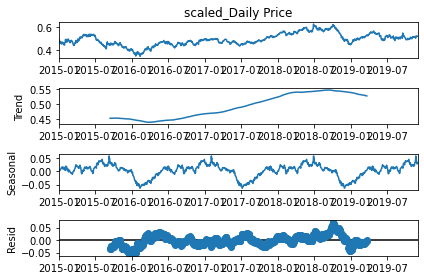

In [3]:
desc = ''
daily_price = EIA_Series('Daily Price','PET.RWTC.D')
dep.ingest(daily_price)

x = daily_price.scaled.asfreq(freq='B').fillna(method='ffill')
x = x['2015-01-01':'2019-12-01']
result = seasonal_decompose(x, model='additive',period=365)  
result.plot();

In [4]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(x,autolag='AIC')
print(dftest)

(-2.0524919283853738, 0.26404162200840053, 1, 1280, {'1%': -3.435469111362934, '5%': -2.8638006501960755, '10%': -2.567973589477539}, -9154.0444811847)


## Auto Arima

In [5]:
auto_arima(x,start_p=1,start_q=1,max_p = 10,max_q=10,seasonal=True,trace=True,m=365)

Performing stepwise search to minimize aic


C:\Users\umark\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: 

In [ ]:
span = 365
alpha = 2/(span+1) # Standard span formula



model =SimpleExpSmoothing(x)

fitted_model = model.fit(
    smoothing_level=alpha,
    optimized=False)
fitted_model = model.fit()

daily_price.frame['SimpleExp'] = fitted_model.fittedvalues.shift(-1) 

df_slice = daily_price.frame[['SimpleExp','scaled_Daily Price']]

df_slice['2016-01-01':'2016-06-01'].plot(figsize=(10,20))




# ARIMA

# Daily Production

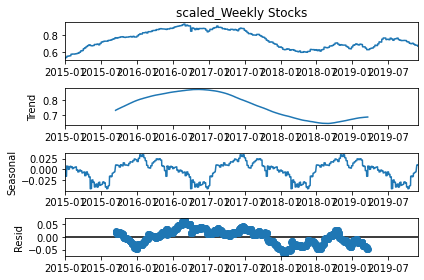

In [20]:
desc = ''
daily_production = EIA_Series('Weekly Stocks','PET.WTTSTUS1.W')
dep.ingest(daily_production)

x2 = daily_production.scaled.asfreq(freq='B').fillna(method='ffill')
x2 = x2['2015-01-01':'2019-12-01']
result = seasonal_decompose(x2, model='additive',period=365)  
result.plot();

In [ ]:
granger_frame = pd.concat([x,x2],axis=1)
granger_frame.columns = ['price','stocks']
granger_frame.head()
g_test = grangercausalitytests(granger_frame,maxlag=90);

In [ ]:
print(g_test[1])

In [24]:
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import pandas as pd
import plotly

y = x.index

trace1 = go.Scatter(
        x=y,
        y=x,
        mode='lines',
        name='Spot Price'
)

trace2 = go.Scatter(
    x=x2.index,
    y=x2,
    mode='lines',
    name = 'Weekly Inventory')

data = [trace1,trace2]

layout = go.Layout(
    title = 'Daily Stocks',
    xaxis = {
        'title':'Time',
    },
    yaxis = dict(
        title='Scaled price'
        ),
    hovermode='closest'
)

fig = go.Figure(data=data, layout = layout)

plotly.offline.iplot(fig,filename='daily_price')

# Monthly Crude Imports

In [ ]:
desc = 'US imports of crude oil, monthly'

monthly_imports = EIA_Series('Monthly Imports','PET.MCRIMUS1.M',desc,date_format='%Y%m' )
dep.ingest(monthly_imports)

x = monthly_imports.scaled
x = x['2000-01-01':]

result = seasonal_decompose(x, model='additive',period=12)  
result.plot();


In [ ]:
ds = Dataset(dep.originals)

In [ ]:
ds['Monthly Imports'].show_report()

## Dow Jones

In [ ]:
df_dow = pd.read_csv('data/dji.csv')

df_dow['Date']=pd.to_datetime(df_dow['Date'])
        
df_dow.set_index(df_dow['Date'],drop=True,inplace=True)

df_dow.columns

In [ ]:
desc = 'US imports of crude oil, monthly'

x = df_dow['Close']
x = x['2000-01-01':]

result = seasonal_decompose(x, model='additive',period=365)  
result.plot();

In [ ]:
df_dow['Close'].plot()

In [ ]:
df_dow['delta_dow']  = df_dow['Close'].diff()

X = df_dow[['delta_dow']]

y = daily_price.series_frame[['deltaDaily Price']]

merged = y.merge(X,how='inner',left_index=True,right_index=True)

In [ ]:
merged.head()

In [ ]:
x=merged['deltaDaily Price']
y=merged['delta_dow']
plt.scatter(x=x,y=y)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

model= LinearRegression()

In [ ]:
model.fit(x.reshape(-1,1),y)

# To-Do

1. Moving averages?
2. Correlation between price and:
3. Features to add/explore:
    a. Active wells?
    b. Refinery inputs?
    c. consumption?
    d. month?
    e. 
    


# SCRAPS

In [ ]:
\
df_eia=functools.reduce(lambda x,y: x.join(y,how='outer'),frame_list)
df_eia.fillna(axis=0,method='ffill',inplace=True)

conn = sqlite3.connect('oilstocks.db')
c = conn.cursor()

for col in df_eia:
    df_eia[col]=preprocessing.scale(df_eia[col])

df_eia.to_sql("scaledstocks",conn,if_exists='replace')
conn.commit()

df_eia.to_sql("crudestocks",conn,if_exists='replace')